# reference

Theory:
https://smartbridge.com/market-basket-analysis-101/
https://www.albionresearch.com/data_mining/market_basket.php
https://docplayer.net/49837678-Apriori-algorithm-professor-anita-wasilewska-book-slides.html
https://www-users.cs.umn.edu/~kumar001/dmbook/index.php

Coding Tutorial:
https://pbpython.com/market-basket-analysis.html
https://towardsdatascience.com/a-gentle-introduction-on-market-basket-analysis-association-rules-fa4b986a40ce
https://www.datacamp.com/community/tutorials/market-basket-analysis-r#apriori

Apriori package:
http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/
http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/
http://rasbt.github.io/mlxtend/user_guide/preprocessing/TransactionEncoder/

Data:
http://archive.ics.uci.edu/ml/datasets/Online+Retail
http://archive.ics.uci.edu/ml/machine-learning-databases/00352/

Daqing Chen, Sai Liang Sain, and Kun Guo, Data mining for the online retail industry: A case study of RFM model-based customer segmentation using data mining, Journal of Database Marketing and Customer Strategy Management, Vol. 19, No. 3, pp. 197â€“208, 2012 (Published online before print: 27 August 2012. doi: 10.1057/dbm.2012.17).
   

In [124]:
from datetime import datetime
from typing import List, Dict
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder


# Read the data

In [3]:
path = r"C:\Users\richard.liang\OneDrive - insidemedia.net\project\market-basket-analysis\data"
data_name = 'Online Retail.csv'

df_original = pd.read_csv(path + '/' + data_name)

# Overview the data


In [56]:
print('shape of the data is', df_original.shape)
df_original.head(10)

shape of the data is (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


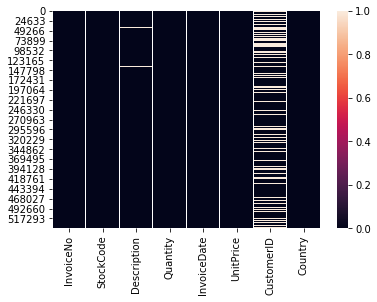

In [5]:
# Show the missing values
sns.heatmap(df_original.isnull())
plt.show()

# customerID is missing a lot of data. I think it is normal because if you buy online without registration,
# the system will not have your ID

# Clean the data

In [57]:
def missing_percent(df: pd.DataFrame) -> Dict:
    """Calculate the percentage of the missing data in each columns"""
    percent = {}
    for column_name in list(df.columns):
        percent[column_name] = sum(df[column_name].isnull()) / df[column_name].count()
    return percent

### Calculate the percentage of the missing data in each columns


In [58]:
percent = missing_percent(df_original)
percent

# 33% of the rows have no customer ID.

{'InvoiceNo': 0.0,
 'StockCode': 0.0,
 'Description': 0.002690325744048996,
 'Quantity': 0.0,
 'InvoiceDate': 0.0,
 'UnitPrice': 0.0,
 'CustomerID': 0.33203139402549964,
 'Country': 0.0}

### Drop some rows that have missing value in some columns

In [59]:
def dropna_rows(df: pd.DataFrame, columns: List) -> pd.DataFrame:
    """ 
    Drop the missing rows given the selected columns
    If those columns have any missing data in some rows, need to exclude those rows.
    """
    df_drop = df.dropna(axis=0, how='any', subset=columns)
    return df_drop

In [60]:
# The description, invoice number, quantity cannot be empty. If any of them is empty, there might be something wrong in the 
# system, those rows will be deleted
columns = ['Description', 'Quantity', 'InvoiceNo']

df = dropna_rows(df_original, columns)
print(df.shape)

(540455, 8)


### Check the percentage of the missing value again


In [61]:
percent = missing_percent(df)
percent

# Only CustomerID column has missing value now. Leave it as it is.

{'InvoiceNo': 0.0,
 'StockCode': 0.0,
 'Description': 0.0,
 'Quantity': 0.0,
 'InvoiceDate': 0.0,
 'UnitPrice': 0.0,
 'CustomerID': 0.3284574108532086,
 'Country': 0.0}

### Check the rows that have negative quantity 


In [62]:
nagative_quantity = df[df.Quantity <= 0]
nagative_quantity.head(5)

# Many of the negative quantity is because the order was cancelled, need to remove them.

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom


In [63]:
# Select the positive quantity
df = df[df.Quantity > 0]

### check the canceled orders.


In [13]:
cancel_order = df[(df['InvoiceNo'].astype(str).str.contains('c|C', regex=True))]
cancel_order.head(10)

# All the cancel order was removed if I only select the positive quantity

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [14]:
# For sure, you can remove the cancel order by looking at the name of the InvoiceID and exclude them
df = df[~(df['InvoiceNo'].astype(str).str.contains('c|C', regex=True))]

### Some of the product description have extra space, better to remove them


In [15]:
df['Description'] = df.Description.str.strip()
df['Description'] = df.Description.apply(lambda s: re.sub(' +', ' ', s))


### In part of the data, there are more than two product in one row, remove them

In [64]:
# for example
df[df.Description.str.contains('SUGAR')].head(5)

# this doesn't make any sense because because the data is suppose contain only one product per row. If there are two products,
# what does the UnitPrice stands for? Check InvoiceNo 536638 and 536864. They are the same product but have different UnitPrice.
# Thus, I remove those rows.


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1922,536544,21216,"SET 3 RETROSPOT TEA,COFFEE,SUGAR",1,12/1/2010 14:32,11.02,NaN,United Kingdom
3619,536638,21216,"SET 3 RETROSPOT TEA,COFFEE,SUGAR",4,12/2/2010 11:41,4.95,16244.0,United Kingdom
3929,536739,85159A,"BLACK TEA,COFFEE,SUGAR JARS",2,12/2/2010 13:08,6.35,14180.0,United Kingdom
4996,536836,21531,RED RETROSPOT SUGAR JAM BOWL,2,12/2/2010 18:08,2.55,18168.0,United Kingdom
5507,536864,21216,"SET 3 RETROSPOT TEA,COFFEE,SUGAR",1,12/3/2010 11:27,11.02,NaN,United Kingdom


In [19]:
def remove_comma_end(s):
    """ Remove the comma at the end of the description"""
    if s.rfind(',') == len(s)-1:
        s = s[:-1]
        
    return s

# If there is a comman at the end of the product description, remove it
df['Description'] = df.Description.apply(remove_comma_end)


In [66]:
# There are 2 or more product if there is 1 or more comma in the middle of the description
num_items_per_row = df.Description.str.split(',').apply(lambda x: len(x))

# Return the row index that have more than 2 items per row
list1 = list(num_items_per_row[num_items_per_row >= 2].index)

# pick up the rows that have more than two items
df_more_than_one_product_in_a_row = df[df.index.isin(list1)]
print(df_more_than_one_product_in_a_row.Description.head(20))
ratio = df_more_than_one_product_in_a_row.shape[0] / df.shape[0]
print('\n The number of more than two product in a row in the data is', df_more_than_one_product_in_a_row.shape[0],
      'the proportion to the total number of rows is', ratio)

109              AIRLINE LOUNGE,METAL SIGN
253             FANCY FONT BIRTHDAY CARD, 
956                 TRAY, BREAKFAST IN BED
1014    SWISS ROLL TOWEL, CHOCOLATE  SPOTS
1083    SWISS ROLL TOWEL, CHOCOLATE  SPOTS
1214             BIRTHDAY CARD, RETRO SPOT
1215            FANCY FONT BIRTHDAY CARD, 
1257            FANCY FONT BIRTHDAY CARD, 
1664                TRAY, BREAKFAST IN BED
1719            ACRYLIC JEWEL ICICLE, PINK
1743                      TUMBLER, BAROQUE
1744                  TUMBLER, NEW ENGLAND
1750        METAL SIGN,CUPCAKE SINGLE HOOK
1751        METAL SIGN,CUPCAKE SINGLE HOOK
1922      SET 3 RETROSPOT TEA,COFFEE,SUGAR
1950             ELEPHANT, BIRTHDAY CARD, 
2104                FEATHER PEN,COAL BLACK
2105                FEATHER PEN,LIGHT PINK
2106                FEATHER PEN,LIGHT PINK
2107                FEATHER PEN,COAL BLACK
Name: Description, dtype: object

 The number of more than two product in a row in the data is 4721 the proportion to the total number of ro

In [67]:
# Remove those rows

df  = df[~df.index.isin(list1)]


print('After clean the data, the shape of the data is', df.shape)

After clean the data, the shape of the data is (525972, 8)


# Analyze the data

## Process the data

In [68]:
def get_percentage(df: pd.DataFrame, column_name: str) -> pd.DataFrame:
    """ Add a column shows the percentage format of the column you specify"""
    new_column_name = column_name + '_percentage'
    df[new_column_name] = df[column_name] / df[column_name].sum()
    df[new_column_name] = df[new_column_name].map('{: .2%}'.format)
    return df

In [69]:
# Add a column for sales
df['Sales'] = df.Quantity * df.UnitPrice
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00


In [70]:
df['InvoiceDate'] = pd.to_datetime(df.InvoiceDate, infer_datetime_format=True)


In [71]:
df.shape

(525972, 9)

## (1) Analyze the product

### (1.1) Quantity by product


                                    Quantity Quantity_percentage
Description                                                     
medium ceramic top storage jar         78033               1.42%
world war 2 gliders asstd designs      55047               1.00%
jumbo bag red retrospot                48478               0.88%
white hanging heart t-light holder     37895               0.69%
popcorn holder                         36761               0.67%
assorted colour bird ornament          36461               0.66%
pack of 72 retrospot cake cases        36419               0.66%
rabbit night light                     30788               0.56%
mini paint set vintage                 26633               0.48%
pack of 12 london tissues              26339               0.48%


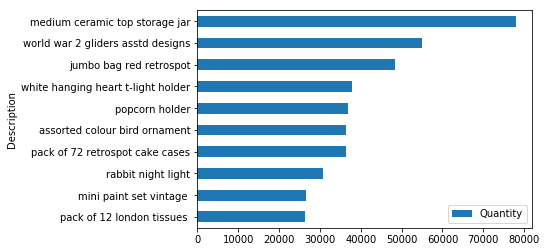

In [72]:
df_product_quantity = df.groupby(by='Description').agg({'Quantity': np.sum}).sort_values(by='Quantity', ascending=False)
df_product_quantity = get_percentage(df_product_quantity, 'Quantity')

# convert the product name to lower case
df_product_quantity.set_index(df_product_quantity.index.str.lower(), inplace=True) 

df_print = df_product_quantity.head(10)
print(df_print)
df_plot = df_print.iloc[::-1]
df_plot.plot.barh()

###  (1.2) Price by product


                                      UnitPrice
Description                                    
amazon fee                          6880.545000
picnic basket wicker 60 pieces       649.500000
dotcom postage                       291.311822
manual                               225.941402
rustic  seventeen drawer sideboard   158.076923
regency mirror with shutters         156.428571
vintage blue kitchen cabinet         146.750000
vintage red kitchen cabinet          143.421053
chest natural wood 20 drawers        118.076923
love seat antique white metal        114.024390


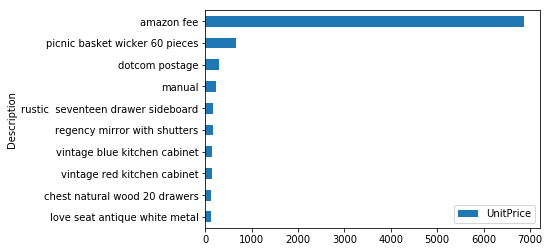

In [73]:
df_product_price = df.groupby(by='Description').agg({'UnitPrice': np.mean}).sort_values(by='UnitPrice', ascending=False)

# convert the product name to lower case
df_product_price.set_index(df_product_price.index.str.lower(), inplace=True) 

df_print = df_product_price.head(10)
print(df_print.head(10))
df_plot = df_print.iloc[::-1]
df_plot.plot.barh()

# I am wondering what is amazon fee?

In [74]:
# I am suspicious about the 'amazon fee'
df[df.Description.str.lower().str.contains('amazon fee')]


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
15017,537632,AMAZONFEE,AMAZON FEE,1,2010-12-07 15:08:00,13541.33,NaN,United Kingdom,13541.33
135534,547901,AMAZONFEE,AMAZON FEE,1,2011-03-28 11:57:00,219.76,NaN,United Kingdom,219.76


### (1.3) Sales by product


                                        Sales Sales_percentage
Description                                                   
dotcom postage                      206248.77            1.98%
regency cakestand 3 tier            174484.74            1.67%
white hanging heart t-light holder  106292.77            1.02%
party bunting                        99504.33            0.95%
jumbo bag red retrospot              94340.05            0.90%
medium ceramic top storage jar       81700.92            0.78%
manual                               78112.82            0.75%
postage                              78101.88            0.75%
rabbit night light                   66964.99            0.64%
paper chain kit 50's christmas       64952.29            0.62%


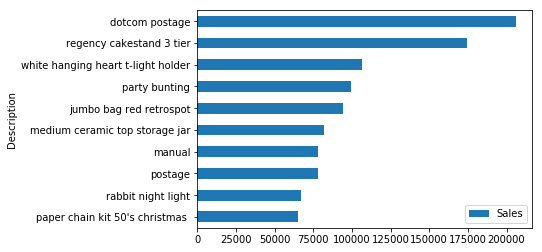

In [75]:
df_product_sales = df.groupby(by='Description').agg({'Sales': np.sum}).sort_values(by='Sales', ascending=False)

# convert the product name to lower case
df_product_sales.set_index(df_product_sales.index.str.lower(), inplace=True) 
df_product_sales = get_percentage(df_product_sales, 'Sales')

df_print = df_product_sales.head(10)
print(df_print)

df_plot = df_print[::-1]
ax = df_plot.plot.barh()


### (1.4) number of unique customer buy the  product 

Description
regency cakestand 3 tier              881
white hanging heart t-light holder    856
party bunting                         708
assorted colour bird ornament         678
set of 3 cake tins pantry design      640
pack of 72 retrospot cake cases       635
jumbo bag red retrospot               635
paper chain kit 50's christmas        613
natural slate heart chalkboard        587
baking set 9 piece retrospot          581
dtype: int64


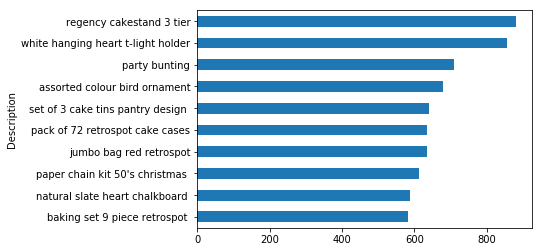

In [76]:
df_product_customer = df.groupby(by='Description').apply(lambda x: x['CustomerID'].nunique()).sort_values(ascending=False)

# convert the product name to lower case
df_product_customer.index = df_product_customer.index.str.lower() 

df_print = df_product_customer.head(10)
print(df_print)

df_plot = df_print[::-1]
ax = df_plot.plot.barh()


## (2) Analyze locations

### (2.1) Quantity by country

                Quantity Quantity_percentage
Country                                     
United Kingdom   4584839              83.29%
Netherlands       199629               3.63%
EIRE              146283               2.66%
Germany           118669               2.16%
France            111833               2.03%
Australia          82265               1.49%
Sweden             35795               0.65%
Switzerland        30478               0.55%
Spain              27736               0.50%
Japan              25692               0.47%


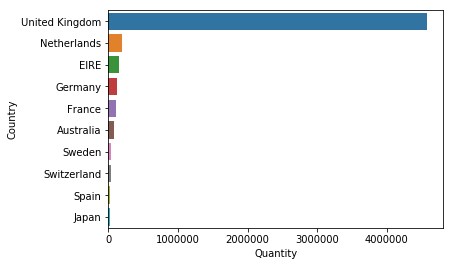

In [77]:
df_country_quantity = df.groupby(by='Country').agg({'Quantity': np.sum}).sort_values(by='Quantity', ascending=False)
df_country_quantity = get_percentage(df_country_quantity, 'Quantity')

df_print = df_country_quantity.head(10)
print(df_print)

# plot
df_plot = df_print.reset_index()
sns.barplot(data=df_plot, y='Country', x='Quantity')

###  (2.2) Sales by country


                       Sales Sales_percentage
Country                                      
United Kingdom  8.794209e+06           84.34%
Netherlands     2.842255e+05            2.73%
EIRE            2.822818e+05            2.71%
Germany         2.279416e+05            2.19%
France          2.095054e+05            2.01%
Australia       1.367742e+05            1.31%
Spain           6.143539e+04            0.59%
Switzerland     5.690378e+04            0.55%
Belgium         4.103821e+04            0.39%
Sweden          3.815657e+04            0.37%


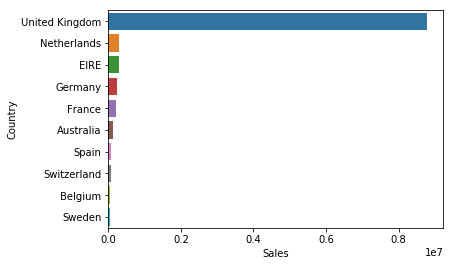

In [78]:
df_country_sales = df.groupby(by='Country').agg({'Sales': np.sum}).sort_values(by='Sales', ascending=False)
df_country_sales = get_percentage(df_country_sales, 'Sales')
print(df_country_sales.head(10))

# plot
df_plot = df_country_sales.head(10).reset_index()
sns.barplot(data=df_plot, y='Country', x='Sales')

## (3) Time analysis

### (3.1) By hour

###  Quantity  by hour

Text(0, 0.5, 'Quantity')

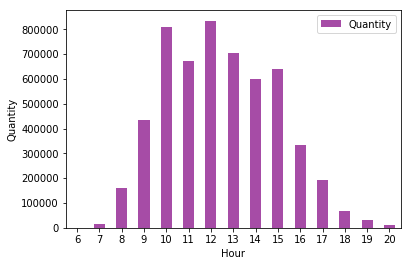

In [79]:
fig = plt.figure(figsize=(6,4))
axes = fig.add_subplot(1, 1, 1)

df_hour_quantity = df.groupby(by=df.InvoiceDate.dt.hour).agg({'Quantity': np.sum})
df_hour_quantity.index.name = 'Hour'
df_hour_quantity.plot.bar(ax=axes, rot=0, color='purple', alpha=0.7)
axes.set_ylabel('Quantity')

### Sales by hour


Text(0, 0.5, 'Sales')

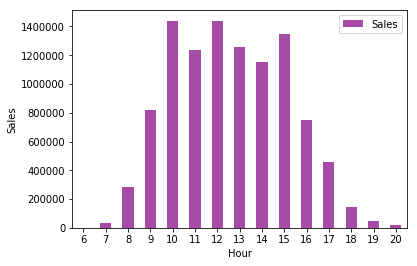

In [80]:
fig = plt.figure(figsize=(6,4))
axes = fig.add_subplot(1, 1, 1)

df_hour_sales = df.groupby(by=df.InvoiceDate.dt.hour).agg({'Sales': np.sum})
df_hour_sales.index.name = 'Hour'
df_hour_sales.plot.bar(ax=axes, rot=0, color='purple', alpha=0.7)
axes.set_ylabel('Sales')

### Number of transactions by hour

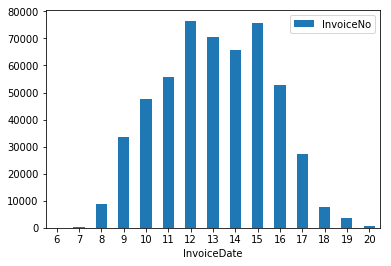

In [81]:
df_hour_transaction = df.groupby(by=df.InvoiceDate.dt.hour).agg({'InvoiceNo': 'count'})
df_hour_transaction.plot.bar(rot=False)

### (3.2) By month

### Sales by month


Text(0, 0.5, 'Sales')

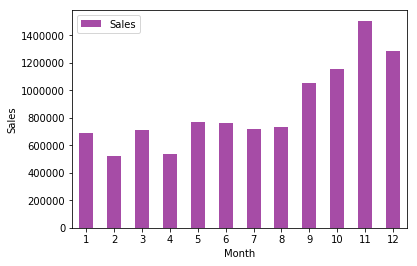

In [82]:
fig = plt.figure(figsize=(6,4))
axes = fig.add_subplot(1, 1, 1)

df_hour_sales = df.groupby(by=df.InvoiceDate.dt.month).agg({'Sales': np.sum})
df_hour_sales.index.name = 'Month'
df_hour_sales.plot.bar(ax=axes, rot=0, color='purple', alpha=0.7)
axes.set_ylabel('Sales')

### Number of Transaction by month

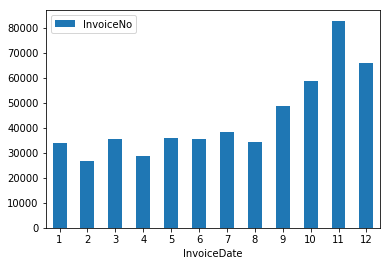

In [83]:
df_month_transaction = df.groupby(by=df.InvoiceDate.dt.month).agg({'InvoiceNo': 'count'})
df_month_transaction.plot.bar(rot=False)

### (3.3) Sales by day of week


Text(0, 0.5, 'Sales')

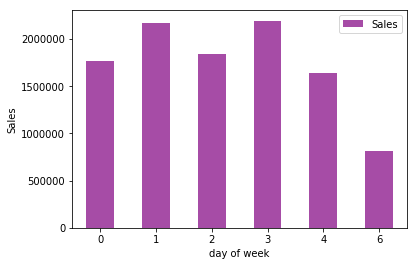

In [84]:
fig = plt.figure(figsize=(6,4))
axes = fig.add_subplot(1, 1, 1)

df_hour_sales = df.groupby(by=df.InvoiceDate.dt.dayofweek).agg({'Sales': np.sum})
df_hour_sales.index.name = 'day of week'
df_hour_sales.plot.bar(ax=axes, rot=0, color='purple', alpha=0.7)
axes.set_ylabel('Sales')

## (4) customer analysis

### Number of purchase for each unique customers

In [85]:
unique_customer = df['CustomerID'].value_counts().sort_values(ascending=False)
print(unique_customer)

17841.0    7795
14911.0    5638
14096.0    5027
12748.0    4563
14606.0    2641
15311.0    2355
14646.0    2066
13089.0    1793
13263.0    1641
14298.0    1601
15039.0    1499
14156.0    1392
18118.0    1265
14159.0    1199
14796.0    1123
16033.0    1119
14056.0    1104
15005.0    1099
14769.0    1083
13081.0    1022
16549.0     978
14527.0     963
17511.0     960
14456.0     960
15719.0     934
16931.0     890
15555.0     889
17811.0     841
14505.0     795
18283.0     756
           ... 
18184.0       1
17986.0       1
18084.0       1
18113.0       1
17752.0       1
18068.0       1
18268.0       1
17925.0       1
17763.0       1
17923.0       1
18233.0       1
18133.0       1
15510.0       1
13366.0       1
14424.0       1
17715.0       1
13391.0       1
13747.0       1
13841.0       1
14090.0       1
14351.0       1
14705.0       1
17747.0       1
15070.0       1
15118.0       1
15195.0       1
15313.0       1
15316.0       1
13703.0       1
12346.0       1
Name: CustomerID, Length

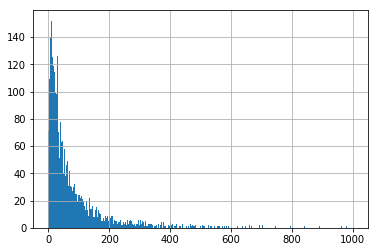

In [86]:
unique_customer.hist(bins=500, range=(0, 1000))

### the distribution of how many different products each transaction 

Text(0.5, 0, 'Number of products')

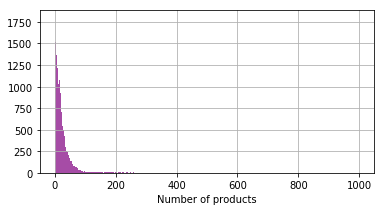

In [87]:
fig, axes = plt.subplots(1, 1, figsize=(6, 3))

df_plot = df.groupby(by='InvoiceNo').apply(lambda x: x['Description'].nunique())
df_plot.hist(ax=axes, bins=500, range=(0, 1000), color='purple', alpha=0.7)
axes.set_xlabel('Number of products')

### the distribution of how many different products each customer buy

Text(0.5, 0, 'Number of products')

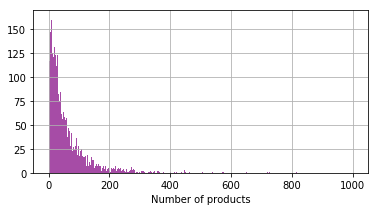

In [88]:
fig, axes = plt.subplots(1, 1, figsize=(6, 3))

df_plot = df.groupby(by='CustomerID').apply(lambda x: x['Description'].nunique())

df_plot.hist(ax=axes, bins=500, range=(0, 1000), color='purple', alpha=0.7)
axes.set_xlabel('Number of products')

### the distribution of how much customer spend


Text(0.5, 0, 'Spend')

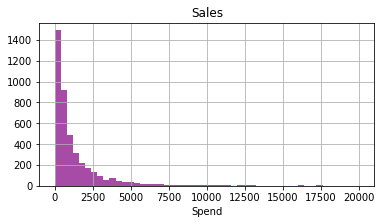

In [89]:
fig, axes = plt.subplots(1, 1, figsize=(6, 3))

df.groupby(by='CustomerID').agg({'Sales':np.sum}).hist(ax=axes, bins=50, range=(0,20000), color='purple', alpha=0.7)
axes.set_xlabel('Spend')

### number of unique customer for each country

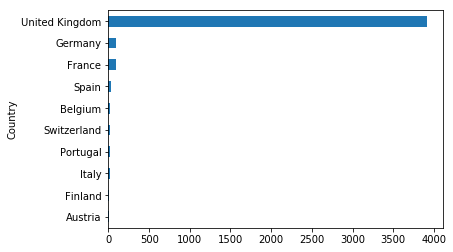

In [90]:
df_country_customer = df.groupby('Country').apply(lambda x: x['CustomerID'].nunique()).sort_values(ascending=False)
df_country_customer.head(10).iloc[::-1].plot.barh()

### number of unique customer for each month

Text(0, 0.5, 'number of unique customers')

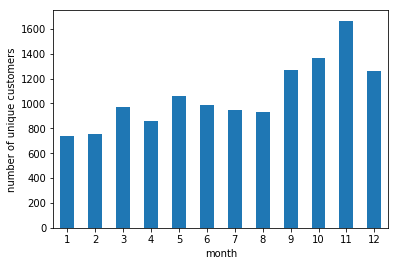

In [91]:
df_month_customer = df.groupby(by=df['InvoiceDate'].dt.month).apply(lambda x: x['CustomerID'].nunique())

df_plot = df_month_customer
ax = df_plot.plot.bar(rot=0)
ax.set_xlabel('month')
ax.set_ylabel('number of unique customers')

### number of unique customer by day of week

Text(0, 0.5, 'number of unique customers')

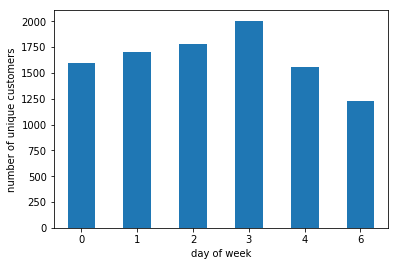

In [92]:
df_dayofweek_customer = df.groupby(by=df['InvoiceDate'].dt.dayofweek).apply(lambda x: x['CustomerID'].nunique())

df_plot = df_dayofweek_customer
ax = df_plot.plot.bar(rot=0)
ax.set_xlabel('day of week')
ax.set_ylabel('number of unique customers')

# Working with Sparse Representations  # to do

In [ ]:
#te = TransactionEncoder()
#te_ary = te.fit(df).transform(df, sparse=True)
#sparse_df = pd.SparseDataFrame(te_ary, columns=te.columns_, default_fill_value=False)
#sparse_df

# Transform the data to the format that the package needs

In [93]:
# Transform the data into the correct format required by the algorithm
#?? df = df.loc[df['Country'] == 'France', :]       # select France as the test

basket = (df.pivot_table(index='InvoiceNo',columns='Description', values='Quantity', aggfunc=np.sum, fill_value=0)
          .reset_index().set_index('InvoiceNo'))

basket.head(13)



Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,returned,taig adjust,test,to push order througha s stock was,website fixed,wrongly coded 20713,wrongly coded 23343,wrongly marked,wrongly marked 23343,wrongly sold (22719) barcode
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536370,0,0,0,0,0,0,0,0,24,0,...,0,0,0,0,0,0,0,0,0,0
536371,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536372,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536373,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [95]:
print(basket.shape)

# There are 3991 different products.

(20127, 4009)


In [96]:
# In order to use the apriori algorithm, need to specify each element eight 1(true) or 0(false)

basket_sets = basket.where(basket == 0, 1 )
#?? basket_sets.drop('POSTAGE', inplace=True, axis=1)
basket_sets.head(13)

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,returned,taig adjust,test,to push order througha s stock was,website fixed,wrongly coded 20713,wrongly coded 23343,wrongly marked,wrongly marked 23343,wrongly sold (22719) barcode
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536370,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
536371,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536372,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536373,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [97]:
# density of the sparse matrix

density = basket_sets.sum().sum() / (basket_sets.shape[0] * basket_sets.shape[1])
print('density of the sparse matrix is ', density)

density of the sparse matrix is  0.006387637553666917


# Apply the apriori algorithm
apriori(df, min_support=0.5, use_colnames=False, max_len=None, n_jobs=1)




## 1. Generate frequent itemsets

In [51]:
# Apply the apriori algorithm
frequent_itemsets = apriori(basket_sets, min_support=0.01, use_colnames=True, max_len=None, n_jobs=8).sort_values(
    by='support',ascending=False)

frequent_itemsets 


,support,itemsets
764,0.112287,(WHITE HANGING HEART T-LIGHT HOLDER)
337,0.103940,(JUMBO BAG RED RETROSPOT)
544,0.098822,(REGENCY CAKESTAND 3 TIER)
451,0.083768,(PARTY BUNTING)
374,0.077707,(LUNCH BAG RED RETROSPOT)
46,0.072291,(ASSORTED COLOUR BIRD ORNAMENT)
612,0.068813,(SET OF 3 CAKE TINS PANTRY DESIGN)
430,0.065584,(PACK OF 72 RETROSPOT CAKE CASES)
376,0.063845,(LUNCH BAG SUKI DESIGN)
368,0.063248,(LUNCH BAG BLACK SKULL.)


In [98]:
# Filtering result you want

# Add an extra column indicate the length of the products
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

frequent_itemsets_filter = frequent_itemsets[ (frequent_itemsets['length'] == 1) & (frequent_itemsets['support'] >= 0.01) ]
frequent_itemsets_filter

,support,itemsets,length
764,0.112287,(WHITE HANGING HEART T-LIGHT HOLDER),1
337,0.103940,(JUMBO BAG RED RETROSPOT),1
544,0.098822,(REGENCY CAKESTAND 3 TIER),1
451,0.083768,(PARTY BUNTING),1
374,0.077707,(LUNCH BAG RED RETROSPOT),1
46,0.072291,(ASSORTED COLOUR BIRD ORNAMENT),1
612,0.068813,(SET OF 3 CAKE TINS PANTRY DESIGN),1
430,0.065584,(PACK OF 72 RETROSPOT CAKE CASES),1
376,0.063845,(LUNCH BAG SUKI DESIGN),1
368,0.063248,(LUNCH BAG BLACK SKULL.),1


In [99]:
frequent_itemsets_filter = frequent_itemsets[ (frequent_itemsets['length'] == 2) & (frequent_itemsets['support'] >= 0.01) ]
frequent_itemsets_filter

,support,itemsets,length
1171,0.040990,"(JUMBO BAG PINK POLKADOT, JUMBO BAG RED RETROS...",2
1016,0.038158,"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",2
1214,0.035972,"(JUMBO BAG RED RETROSPOT, JUMBO STORAGE BAG SUKI)",2
1212,0.033785,"(JUMBO SHOPPER VINTAGE RED PAISLEY, JUMBO BAG ...",2
1395,0.032494,"(LUNCH BAG RED RETROSPOT, LUNCH BAG SUKI DESIGN)",2
1350,0.031848,"(LUNCH BAG RED RETROSPOT, LUNCH BAG BLACK SKULL.)",2
830,0.031798,"(ALARM CLOCK BAKELIKE RED, ALARM CLOCK BAKELIK...",2
1010,0.031450,"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...",2
1383,0.030109,"(LUNCH BAG PINK POLKADOT, LUNCH BAG RED RETROS...",2
1503,0.029761,"(ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY...",2


In [105]:
# Frozensets. Pick up the set you want
frequent_itemsets[ frequent_itemsets['itemsets'] == {'WHITE HANGING HEART T-LIGHT HOLDER'} ]


,support,itemsets,length
764,0.112287,(WHITE HANGING HEART T-LIGHT HOLDER),1


## 2. Association Rules Generation from Frequent Itemsets
association_rules(df, metric='confidence', min_threshold=0.8, support_only=False)



### Filter by confidence

In [106]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.8).sort_values(
    by='confidence',ascending=False)
rules.to_csv('rules.csv')
rules


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
76,"(JAM MAKING SET PRINTED, SUKI SHOULDER BAG)",(DOTCOM POSTAGE),0.010831,0.035177,0.010384,0.958716,27.254334,0.010003,23.370166
91,"(HERB MARKER THYME, HERB MARKER PARSLEY)",(HERB MARKER ROSEMARY),0.010583,0.011924,0.010086,0.953052,79.925293,0.009960,21.046013
27,"(REGENCY TEA PLATE PINK, REGENCY TEA PLATE ROSES)",(REGENCY TEA PLATE GREEN),0.013365,0.018930,0.012670,0.947955,50.077423,0.012417,18.850563
92,"(HERB MARKER ROSEMARY, HERB MARKER PARSLEY)",(HERB MARKER THYME),0.010682,0.011775,0.010086,0.944186,80.184104,0.009960,17.705694
49,(HERB MARKER THYME),(HERB MARKER ROSEMARY),0.011775,0.011924,0.010980,0.932489,78.200897,0.010840,14.635872
38,"(WOODEN TREE CHRISTMAS SCANDINAVIAN, WOODEN HE...",(WOODEN STAR CHRISTMAS SCANDINAVIAN),0.012371,0.025438,0.011477,0.927711,36.468821,0.011162,13.481435
50,(HERB MARKER ROSEMARY),(HERB MARKER THYME),0.011924,0.011775,0.010980,0.920833,78.200897,0.010840,12.482839
34,"(STRAWBERRY CHARLOTTE BAG, CHARLOTTE BAG PINK ...",(RED RETROSPOT CHARLOTTE BAG),0.013067,0.051374,0.012024,0.920152,17.910930,0.011352,11.880414
87,"(CHARLOTTE BAG PINK POLKADOT, STRAWBERRY CHARL...",(RED RETROSPOT CHARLOTTE BAG),0.011030,0.051374,0.010136,0.918919,17.886926,0.009569,11.699723
90,"(HERB MARKER THYME, HERB MARKER ROSEMARY)",(HERB MARKER PARSLEY),0.010980,0.011825,0.010086,0.918552,77.679398,0.009956,12.132594


#### How do you check whether the result is correct or not? Calculate by yourselves from the basket_sets

In [ ]:
# HERB MARKER THYME, HERB MARKER PARSLEY)  -> (HERB MARKER ROSEMARY)

In [111]:
support_A = basket_sets[(basket_sets['HERB MARKER THYME'] == 1)  & (basket_sets['HERB MARKER PARSLEY'] == 1)].shape[0]
support_AB  = basket_sets[(basket_sets['HERB MARKER THYME'] == 1) 
                          & (basket_sets['HERB MARKER PARSLEY'] == 1)
                          & (basket_sets['HERB MARKER ROSEMARY'] == 1)].shape[0]

confidence = support_AB / support_A
print(confidence)

0.9530516431924883


#### The result from the algorithm is correct!

### Filter by lift

In [113]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=2).sort_values(by='lift',ascending=False)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
3143,(HERB MARKER THYME),"(HERB MARKER ROSEMARY, HERB MARKER PARSLEY)",0.011775,0.010682,0.010086,0.856540,80.184104,0.009960,6.896127
3142,"(HERB MARKER ROSEMARY, HERB MARKER PARSLEY)",(HERB MARKER THYME),0.010682,0.011775,0.010086,0.944186,80.184104,0.009960,17.705694
3141,"(HERB MARKER THYME, HERB MARKER PARSLEY)",(HERB MARKER ROSEMARY),0.010583,0.011924,0.010086,0.953052,79.925293,0.009960,21.046013
3144,(HERB MARKER ROSEMARY),"(HERB MARKER THYME, HERB MARKER PARSLEY)",0.011924,0.010583,0.010086,0.845833,79.925293,0.009960,6.417841
2214,(HERB MARKER THYME),(HERB MARKER ROSEMARY),0.011775,0.011924,0.010980,0.932489,78.200897,0.010840,14.635872
2215,(HERB MARKER ROSEMARY),(HERB MARKER THYME),0.011924,0.011775,0.010980,0.920833,78.200897,0.010840,12.482839
3140,"(HERB MARKER THYME, HERB MARKER ROSEMARY)",(HERB MARKER PARSLEY),0.010980,0.011825,0.010086,0.918552,77.679398,0.009956,12.132594
3145,(HERB MARKER PARSLEY),"(HERB MARKER THYME, HERB MARKER ROSEMARY)",0.011825,0.010980,0.010086,0.852941,77.679398,0.009956,6.725334
2544,(HERB MARKER THYME),(HERB MARKER PARSLEY),0.011775,0.011825,0.010583,0.898734,76.003457,0.010444,9.758229
2545,(HERB MARKER PARSLEY),(HERB MARKER THYME),0.011825,0.011775,0.010583,0.894958,76.003457,0.010444,9.407900


### Filter by combination of confidence and lift

In [114]:
# output everything first
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0)
rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))

# Filter the result by combination of confidence and lift
rules_filter = rules[ (rules['antecedent_len'] >= 1) & (rules['confidence'] > 0.8) & (rules['lift'] > 2)].sort_values(
    by=['support', 'confidence', 'lift'])

rules_filter



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
3253,"(JUMBO SHOPPER VINTAGE RED PAISLEY, JUMBO BAG ...",(JUMBO BAG RED RETROSPOT),0.012173,0.103940,0.010036,0.824490,7.932364,0.008771,5.105458,3
3283,"(JAM MAKING SET PRINTED, ROSES REGENCY TEACUP ...",(GREEN REGENCY TEACUP AND SAUCER),0.011875,0.050430,0.010036,0.845188,16.759709,0.009437,6.133710,2
3270,"(SUKI SHOULDER BAG, JUMBO STORAGE BAG SUKI)",(DOTCOM POSTAGE),0.011676,0.035177,0.010036,0.859574,24.435954,0.009626,6.870712,2
3200,(HERB MARKER ROSEMARY),"(HERB MARKER THYME, HERB MARKER PARSLEY)",0.011924,0.010583,0.010086,0.845833,79.925293,0.009960,6.417841,1
3201,(HERB MARKER PARSLEY),"(HERB MARKER THYME, HERB MARKER ROSEMARY)",0.011825,0.010980,0.010086,0.852941,77.679398,0.009956,6.725334,1
3199,(HERB MARKER THYME),"(HERB MARKER ROSEMARY, HERB MARKER PARSLEY)",0.011775,0.010682,0.010086,0.856540,80.184104,0.009960,6.896127,1
3202,"(REGENCY TEA PLATE ROSES, GREEN REGENCY TEACUP...",(ROSES REGENCY TEACUP AND SAUCER),0.011129,0.052964,0.010086,0.906250,17.110782,0.009497,10.101721,2
3196,"(HERB MARKER THYME, HERB MARKER ROSEMARY)",(HERB MARKER PARSLEY),0.010980,0.011825,0.010086,0.918552,77.679398,0.009956,12.132594,2
3198,"(HERB MARKER ROSEMARY, HERB MARKER PARSLEY)",(HERB MARKER THYME),0.010682,0.011775,0.010086,0.944186,80.184104,0.009960,17.705694,2
3197,"(HERB MARKER THYME, HERB MARKER PARSLEY)",(HERB MARKER ROSEMARY),0.010583,0.011924,0.010086,0.953052,79.925293,0.009960,21.046013,2


In [115]:
# select some entries

rules_filter[rules_filter['antecedents'] == {'HERB MARKER PARSLEY'}]


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
3201,(HERB MARKER PARSLEY),"(HERB MARKER THYME, HERB MARKER ROSEMARY)",0.011825,0.010980,0.010086,0.852941,77.679398,0.009956,6.725334,1
2648,(HERB MARKER PARSLEY),(HERB MARKER BASIL),0.011825,0.012024,0.010533,0.890756,74.083686,0.010391,9.043784,1
2647,(HERB MARKER PARSLEY),(HERB MARKER MINT),0.011825,0.011924,0.010533,0.890756,74.701050,0.010392,9.044693,1
2593,(HERB MARKER PARSLEY),(HERB MARKER THYME),0.011825,0.011775,0.010583,0.894958,76.003457,0.010444,9.407900,1
2503,(HERB MARKER PARSLEY),(HERB MARKER ROSEMARY),0.011825,0.011924,0.010682,0.903361,75.758141,0.010541,10.224436,1


## plot the result

In [130]:
rules_filter['relationship'] = rules_filter.apply(lambda x: x['antecedents'] + '->' + x['consequents'])

KeyError: ('antecedents', 'occurred at index antecedents')

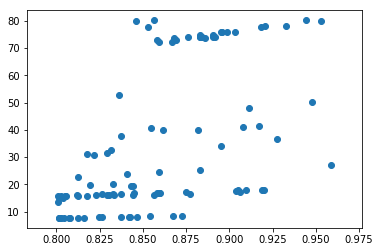

In [126]:
plt.annotate(rules_filter.

# Further investigation

In [ ]:
# Compare the quantity of these items

print(sum(basket['ALARM CLOCK BAKELIKE GREEN']))
print(sum(basket['ALARM CLOCK BAKELIKE RED']))
print(sum(basket['SET/6 RED SPOTTY PAPER PLATES']))
print(sum(basket['SET/6 RED SPOTTY PAPER CUPS']))